In [1]:
import argparse
import os
import time

from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from algo_np.salad_np import Salad
from algo_np.salad_star_np import SaladStar
from algo_np.vr_salad_np import VrSalad
from algo_np.vr_salad_star_np import VrSaladStar
from utils.toy_tools_data import *
from utils.toy_tools_func import *

import sys
sys.argv = [""]

parser = argparse.ArgumentParser()
# parser.add_argument('--method', default="salad", help='set the method')
parser.add_argument('-d', '--dataset_name', default='breast-cancer', help='set the dataset')
parser.add_argument('-n', '--num_clients', default=10, type=int, help='set the number of clients')
parser.add_argument('-m', '--mc_iter', default=200, type=int, help='set the number of Monte Carlo iterations')
parser.add_argument('-b', '--batch_size', default=1, type=int, help='set the mini-batch size')
parser.add_argument('-g', '--lr', default=5e-6, type=float, help='set the learning rate')
# parser.add_argument('-p', '--prob_update_param', default=.05, type=float, help='set the probability of communication')
parser.add_argument('--prop_ula', default=1, type=float, help='set the proportion of data used for each SGLD update')
parser.add_argument('-t', '--temperature', default=1, type=float, help='set the l2 regularization parameter')
parser.add_argument('-l', '--l2', default=1., type=float, help='set the l2 regularization parameter')
# parser.add_argument('-b', '--t_burn_in', default=0, type=int, help='set the burn in period')
parser.add_argument('-s', '--seed', default=-1, type=int, help='set the seed')
args = parser.parse_args()

args.dataset_name='titanic'
args.num_clients=10 
args.mc_iter=250000
args.prop_ula=1
args.batch_size=1
args.lr=1e-2
args.seed=1

# Define the title to save the results
title = args.dataset_name
for key, value in {'numclients_': args.num_clients, 'm_': args.mc_iter, 'g_': args.lr, 'ltwo_': args.l2,
                   'batch_': args.batch_size, 'seed_': args.seed}.items():
    title += '-' + key + str(value)

# Save the path to store the data
path_workdir = '/gpfs/workdir/plassierv/22-fed_avg-neurips/covertype_results/' if os.path.isdir(
    '/gpfs/workdir/plassierv/') else './'
path_dataset = path_workdir + '../../dataset'
path_figures = path_workdir + 'figures/'
path_variables = path_workdir + 'variables/'
path_stats = path_variables + title
path_txt = path_variables + 'text-' + title + '.txt'

# Create the directory if it does not exist
os.makedirs(path_figures, exist_ok=True)
os.makedirs(path_variables, exist_ok=True)

# Set random seed for reproducibility
seed = args.seed if args.seed != -1 else None
rng = np.random.default_rng(1)
np.random.seed(seed)

pprint('--- Get Dataset ---')

if args.dataset_name == 'covertype':
    inputs, targets = fetch_covtype(data_home=path_dataset, download_if_missing=True, return_X_y=True, random_state=42)

    # Transform to binary dataset
    idx = np.where(targets <= 2)[0]
    inputs = inputs[idx]
    targets = targets[idx]

    inputs = StandardScaler().fit_transform(inputs)
    targets = LabelEncoder().fit_transform(targets)

    # Subsample
    max_data_size = np.inf
    if len(targets) > max_data_size:
        id_subset = rng.choice(len(targets), max_data_size, replace=False)
        inputs = inputs[id_subset]
        targets = targets[id_subset]
        print(f'inputs = {np.shape(inputs)}, targets = {np.shape(targets)}')

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(inputs, targets, test_size=0.2, random_state=42)

else:
    Xtrain, Ytrain, Xtest, Ytest = load_UCI_dataset(args.dataset_name, rng, prop=.8)

pprint('--- Generate the heterogeneous dataset ---')

input_dim = Xtrain.shape[1]
output_dim = len(np.unique(Ytrain))
if output_dim == 2:  # for binary logistic regression
    output_dim = 1

oe = OneHotEncoder(sparse=False).fit(Ytrain.reshape(-1, 1))

transform = oe.transform if output_dim > 2 else None
datasets = generate_heterogeneous_classification(Xtrain, Ytrain, args.num_clients, transform, rng)

cfg['paths']['data_path'] = ./data/
DATA_PATH /home/plassier/Bureau/Travaux_Actuels/FedAvgPrivate/codes/bayesian_benchmarks/data/
--- Get Dataset ---
Preparing dataset titanic
Statistics: N=2201, D=4, Xtrain=(1760, 4)
--- Generate the heterogeneous dataset ---


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


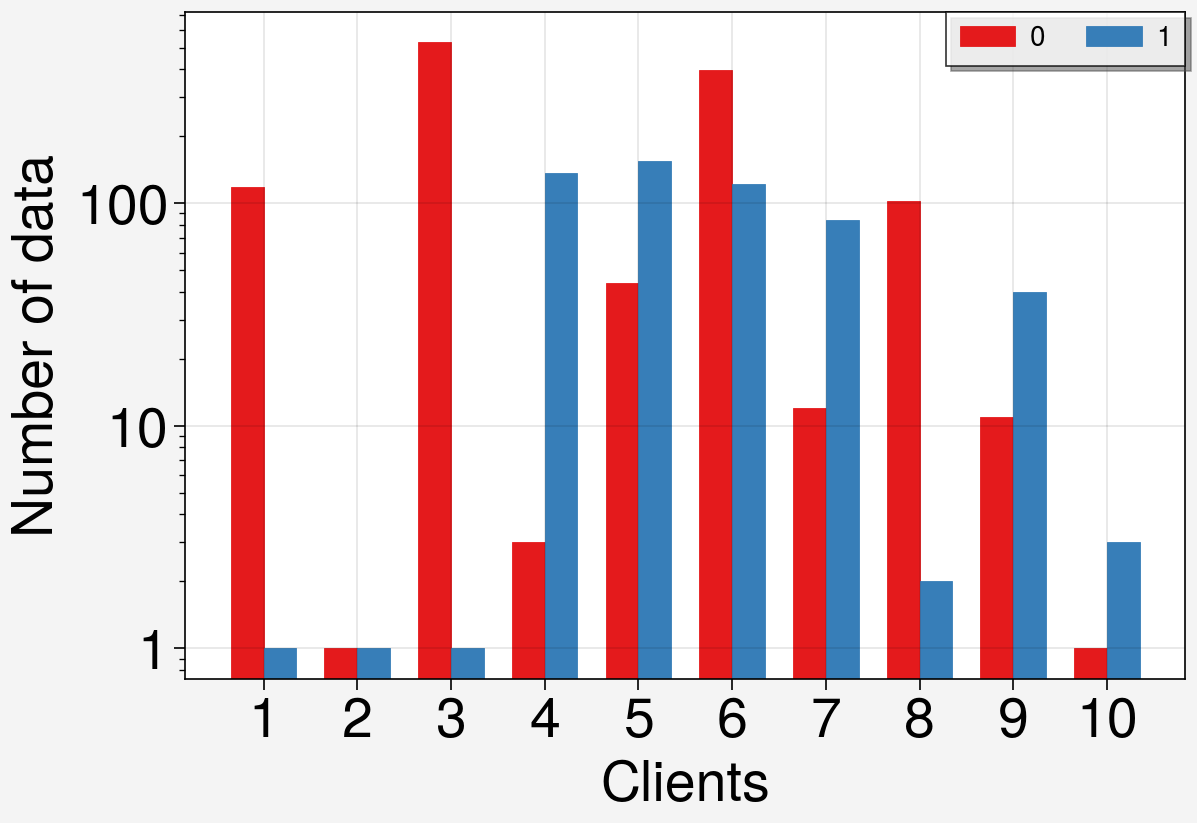

In [11]:
import proplot as pplt
import seaborn as sns

labels_dict = [(str(i + 1), (y == 0).sum(), (y == 1).sum()) for i, (X, y) in enumerate(datasets)]

# Set the color
pplt.rc.cycle = '538'

# Set the palette
sns.set_palette("Set1")  # colorblind, pastel, Set3

y0 = [c0 for _, c0, _ in labels_dict]
y1 = [c1 for _, _, c1 in labels_dict]
clients = [c for c, _, _ in labels_dict]

fig, ax = pplt.subplots(refwidth=5, refaspect=(3, 2))
 
width = 0.35   
ticks = np.arange(len(clients))    
ax.bar(ticks, y0, width, label='0')
ax.bar(ticks + width, y1, width, align="center", label='1')

ax.set_xticks(ticks + width/2)
ax.set_xticklabels(clients)

ax.set_yscale('log')

ax.format(xlabel='Clients', ylabel='Number of data', xtickminor=False, xlocator=np.linspace(0.175, 9.175, num=10), yformatter='scalar', fontsize=20)
ax.legend(loc='best', prop={'size': 10}, frameon=True,
          shadow=True,
          facecolor='white',
          edgecolor='k',
          labelspacing=1,
          handlelength=2)

fig.savefig(os.path.join(path_figures, title + '-client_data.pdf'), bbox_inches='tight')